In [46]:
!pip install numpy --upgrade --force-reinstall


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.


In [47]:
import re
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np


In [48]:
data=pd.read_csv("/content/drive/MyDrive/ANLP_project/validation.csv")

In [49]:
data=data[0:5000]
data.head()

,id,article,highlights
0,61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,21c0bd69b7e7df285c3d1b1cf56d4da925980a68,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,56f340189cd128194b2e7cb8c26bb900e3a848b4,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,00a665151b89a53e5a08a389df8334f4106494c2,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,9f6fbd3c497c4d28879bebebea220884f03eb41a,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [50]:
data=data.drop(columns='id')
# Rename the column 'highlights'
data.rename(columns={'highlights': 'Summary','article':'Article'}, inplace=True)
data.head()

,Article,Summary
0,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [51]:
# Define a basic text preprocessing function
def basic_preprocess(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # keep only alphabet and spaces
    text = re.sub(r'\bs\b', '', text)  # remove standalone 's'
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text



# Apply the preprocessing to Article and Summary
data['clean_Article'] = data['Article'].apply(basic_preprocess)
data['clean_summary'] = data['Summary'].apply(basic_preprocess)
print('Processing Done.🎉🎉🎉')

Processing Done.🎉🎉🎉


In [52]:
data.head()

,Article,Summary,clean_Article,clean_summary
0,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th...",sally forrest an actressdancer who graced the ...,sally forrest an actressdancer who graced the ...
1,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...,a middleschool teacher in china has inked hund...,works include pictures of presidential palace ...
2,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago...",a man convicted of killing the father and sist...,iftekhar murtaza was convicted a year ago of k...
3,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...,avid rugby fan prince harry could barely watch...,prince harry in attendance for englands crunch...
4,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...,a triple m radio producer has been inundated w...,nick slaters colleagues uploaded a picture to ...


In [53]:
# Step 5: Show a sample
print("Original Article:\n", data['Article'][0])
print("\nCleaned Article:\n", data['clean_Article'][0])
print("\nOriginal summary:\n", data['Summary'][0])
print("\nCleaned summary:\n", data['clean_summary'][0])

Original Article:
 Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films such as the 1956 noir While the City Sleeps died on March 15 at her home in Beverly Hills, California. Forrest, whose birth name was Katherine Feeney, was 86 and had long battled cancer. Her publicist, Judith Goffin, announced the news Thursday. Scroll down for video . Actress: Sally Forrest was in the 1951 Ida Lupino-directed film 'Hard, Fast and Beautiful' (left) and the 1956 Fritz Lang movie 'While the City Sleeps' A San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films including the critical and commercial success Not Wanted, Never Fear and Hard, Fast and Beautiful. Some of Forrest's other film credits included Bannerline, Son of Sinbad, and Excuse My Dust, according to her iMDB page. The page also indicates Forrest was in multiple Climax! and Rawhide television episodes. Forrest app

In [54]:
from transformers import T5Tokenizer

# Load T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Add "summarize: " prefix to guide T5
def add_prefix(text):
    return "summarize: " + text

data['Article'] = data['Article'].apply(add_prefix)

# Tokenization function
def tokenize_data(examples):
    model_inputs = tokenizer(
        examples['Article'],
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    labels = tokenizer(
        examples['Summary'],
        max_length=64,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).input_ids

    # Replace padding token id in labels with -100 for loss masking
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs

# Tokenize all data (pass lists instead of whole DataFrame)
tokenized_dataset = tokenize_data({
    'Article': data['Article'].tolist(),
    'Summary': data['Summary'].tolist()
})


print("✅ Tokenization complete.")
print("Input shape:", tokenized_dataset['input_ids'].shape)
print("Label shape:", tokenized_dataset['labels'].shape)


✅ Tokenization complete.
Input shape: torch.Size([5000, 512])
Label shape: torch.Size([5000, 64])


In [55]:
from torch.utils.data import Dataset

class TextSummaryDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


In [56]:
from torch.utils.data import DataLoader, random_split

# Creat a dataset using 'TextSummaryDataset' Class
dataset = TextSummaryDataset(
    input_ids=tokenized_dataset['input_ids'],
    attention_mask=tokenized_dataset['attention_mask'],
    labels=tokenized_dataset['labels']
)

# Split dataset into training and validation ( 80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)


In [57]:
!pip install transformers

In [58]:
from transformers import T5Config, T5ForConditionalGeneration

# Custom config with dropout
config = T5Config.from_pretrained("t5-small")
config.dropout_rate = 0.3  # Default is 0.1; this increases regularization
config.dropout = 0.3

# Load model with config
model = T5ForConditionalGeneration.from_pretrained("t5-small", config=config)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [59]:
from torch.optim import AdamW

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
  # slightly higher LR speeds up convergence


In [60]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
patience=5
trials=2

n_epochs = 30
best_val_loss = float('inf')

In [61]:
from transformers import get_scheduler

num_training_steps = len(train_loader) * n_epochs
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


In [62]:
print("🚀 Start model training...")

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_train_loss = 0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{n_epochs}") as pbar:
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()

            epoch_train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            val_loss = outputs.loss
            epoch_val_loss += val_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"📢 Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_t5_model.pth")
        print(f"✅ Best model saved at epoch {epoch} with Val Loss: {best_val_loss:.4f}")
        trials = 0  # reset counter
    else:
        trials += 1
        if trials >= patience:
            print(f"⏹️ Early stopping at epoch {epoch}")
            break



🚀 Start model training...


Epoch 1/30: 100%|██████████| 2000/2000 [03:38<00:00,  9.16it/s, loss=3.26]


📢 Epoch 1: Train Loss = 3.1459, Val Loss = 2.3365
✅ Best model saved at epoch 1 with Val Loss: 2.3365


Epoch 2/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.45it/s, loss=3.35]


📢 Epoch 2: Train Loss = 2.9423, Val Loss = 2.3540


Epoch 3/30: 100%|██████████| 2000/2000 [03:32<00:00,  9.41it/s, loss=2.88]


📢 Epoch 3: Train Loss = 2.8680, Val Loss = 2.3635


Epoch 4/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.44it/s, loss=3.89]


📢 Epoch 4: Train Loss = 2.8161, Val Loss = 2.3462


Epoch 5/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.45it/s, loss=2.55]


📢 Epoch 5: Train Loss = 2.7769, Val Loss = 2.3365


Epoch 6/30: 100%|██████████| 2000/2000 [03:36<00:00,  9.23it/s, loss=1.89]


📢 Epoch 6: Train Loss = 2.7435, Val Loss = 2.3267
✅ Best model saved at epoch 6 with Val Loss: 2.3267


Epoch 7/30: 100%|██████████| 2000/2000 [03:32<00:00,  9.40it/s, loss=3.33]


📢 Epoch 7: Train Loss = 2.7211, Val Loss = 2.3310


Epoch 8/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.45it/s, loss=2.82]


📢 Epoch 8: Train Loss = 2.6931, Val Loss = 2.3233
✅ Best model saved at epoch 8 with Val Loss: 2.3233


Epoch 9/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.46it/s, loss=2.52]


📢 Epoch 9: Train Loss = 2.6742, Val Loss = 2.3600


Epoch 10/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.44it/s, loss=2.75]


📢 Epoch 10: Train Loss = 2.6567, Val Loss = 2.3326


Epoch 11/30: 100%|██████████| 2000/2000 [03:32<00:00,  9.43it/s, loss=3.15]


📢 Epoch 11: Train Loss = 2.6388, Val Loss = 2.3146
✅ Best model saved at epoch 11 with Val Loss: 2.3146


Epoch 12/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.45it/s, loss=2.44]


📢 Epoch 12: Train Loss = 2.6226, Val Loss = 2.3438


Epoch 13/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.46it/s, loss=2.88]


📢 Epoch 13: Train Loss = 2.6056, Val Loss = 2.3416


Epoch 14/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.46it/s, loss=2.61]


📢 Epoch 14: Train Loss = 2.5951, Val Loss = 2.3047
✅ Best model saved at epoch 14 with Val Loss: 2.3047


Epoch 15/30: 100%|██████████| 2000/2000 [03:32<00:00,  9.40it/s, loss=2.71]


📢 Epoch 15: Train Loss = 2.5850, Val Loss = 2.3087


Epoch 16/30: 100%|██████████| 2000/2000 [03:32<00:00,  9.43it/s, loss=2.47]


📢 Epoch 16: Train Loss = 2.5759, Val Loss = 2.3106


Epoch 17/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.46it/s, loss=2.89]


📢 Epoch 17: Train Loss = 2.5665, Val Loss = 2.3150


Epoch 18/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.44it/s, loss=2.74]


📢 Epoch 18: Train Loss = 2.5560, Val Loss = 2.3216


Epoch 19/30: 100%|██████████| 2000/2000 [03:31<00:00,  9.45it/s, loss=3.36]


📢 Epoch 19: Train Loss = 2.5479, Val Loss = 2.3103
⏹️ Early stopping at epoch 19


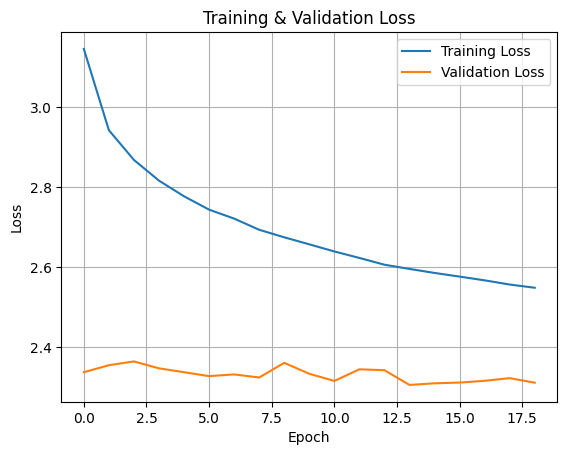

In [63]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [67]:
!pip install evaluate

In [71]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import evaluate


# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.load_state_dict(torch.load("best_t5_model.pth", map_location=torch.device('cpu')))
model.eval()

tokenizer = T5Tokenizer.from_pretrained("t5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load ROUGE metric
import evaluate
rouge = evaluate.load("rouge")

# Function to generate predictions
def generate_summary(text):
    input_ids = tokenizer("summarize: " + text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).input_ids.to(device)
    outputs = model.generate(input_ids=input_ids, max_length=64, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Evaluate on validation set (limit to a small batch for speed)
predictions = []
references = []

for i in range(100):  # Small sample of the val_dataset
    item = val_dataset[i]
    input_text = tokenizer.decode(item['input_ids'], skip_special_tokens=True).replace("summarize: ", "")

    reference_summary = tokenizer.decode(
        [t for t in item['labels'].tolist() if t != -100],  # Filter out -100
        skip_special_tokens=True
    )

    pred_summary = generate_summary(input_text)

    predictions.append(pred_summary)
    references.append(reference_summary)

# Compute ROUGE scores
results = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

# Print ROUGE-1, ROUGE-2, and ROUGE-L
print("📊 ROUGE-1:", results["rouge1"])
print("📊 ROUGE-2:", results["rouge2"])
print("📊 ROUGE-L:", results["rougeL"])


📊 ROUGE-1: 0.39572431822702764
📊 ROUGE-2: 0.18087132915972248
📊 ROUGE-L: 0.28892485916374755


In [73]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [74]:
# Load BERTScore metric
bertscore = evaluate.load("bertscore")

# Compute BERTScore
bertscore_result = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="en"
)

# Print average BERTScore F1
average_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])
print("🤖 BERTScore F1 (avg):", average_f1)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🤖 BERTScore F1 (avg): 0.8802554047107697


In [77]:
for i in range(5):  # Show 5 example summaries
    item = val_dataset[i]
    input_text = tokenizer.decode(item['input_ids'], skip_special_tokens=True).replace("summarize: ", "")
    reference_summary = tokenizer.decode(
        [t for t in item['labels'].tolist() if t != -100],
        skip_special_tokens=True
    )
    predicted_summary = generate_summary(input_text)

    print(f"\n🔹 Example {i+1}")
    print("📥 Original Text:\n", input_text[:250] + "..." if len(input_text) > 250 else input_text)
    print("✅ Reference Summary:\n", reference_summary)
    print("✏️ Predicted Summary:\n", predicted_summary)



🔹 Example 1
📥 Original Text:
 It's not rare for angry hotel guests to create a scene during their stay. But what is less common is when the aggravated customer - is a badger. The stressed-out animal caused a luxury Swedish hotel to lock down on Friday morning after it started run...
✅ Reference Summary:
 Animal entered the Radisson Blu in Stockholm, Sweden, at 5am on Friday. Prevented guests and employees from entering or leaving the building. The stand-off lasted around 40 minutes until police were called in. A game warden was called in, but the angry animal fled before they
✏️ Predicted Summary:
 The stressed-out animal caused a luxury Swedish hotel to lock down on Friday morning after it started running around inside. The 'ill-tempered' badger somehow got in to the Radisson Blu in Stockholm. It prevented guests and employees from going in or out for 40 minutes.

🔹 Example 2
📥 Original Text:
 FIFA President Sepp Blatter says he's concerned by a study highlighting the scale of Russia

📏 Average Input Length: 491.5338


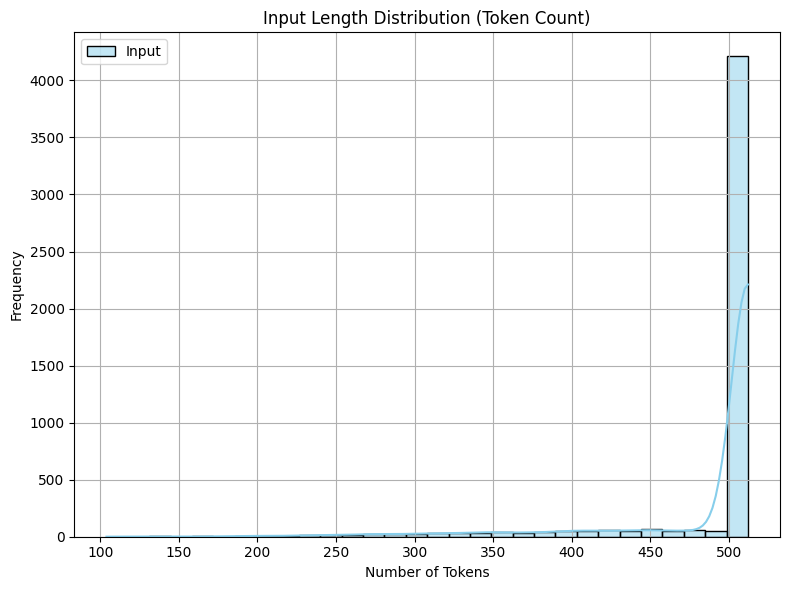

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")

inputs = data['Article'].tolist()
input_lengths = [len(tokenizer.encode(text, truncation=True)) for text in inputs]

print("📏 Average Input Length:", np.mean(input_lengths))

plt.figure(figsize=(8, 6))  # Adjust figsize as needed
sns.histplot(input_lengths, bins=30, color="skyblue", label="Input", kde=True)
plt.title("Input Length Distribution (Token Count)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📏 Average Reference Summary Length: 56.64
📏 Average Predicted Summary Length: 58.92


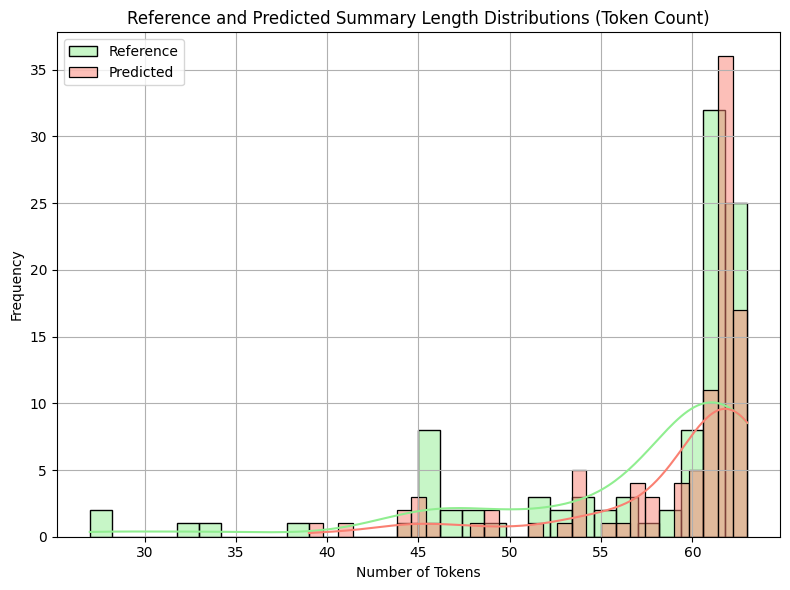

In [81]:
reference_lengths = [len(tokenizer.encode(ref, truncation=True)) for ref in references]
predicted_lengths = [len(tokenizer.encode(pred, truncation=True)) for pred in predictions]

print("📏 Average Reference Summary Length:", np.mean(reference_lengths))
print("📏 Average Predicted Summary Length:", np.mean(predicted_lengths))

plt.figure(figsize=(8, 6))  # Adjust figsize as needed
sns.histplot(reference_lengths, bins=30, color="lightgreen", label="Reference", kde=True)
sns.histplot(predicted_lengths, bins=30, color="salmon", label="Predicted", kde=True)
plt.title("Reference and Predicted Summary Length Distributions (Token Count)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()